In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as cm
import matplotlib.cm
import seaborn as sns
import pandas as pd
import scipy.optimize as opt
import scipy.integrate as scint 

In [2]:
#read the experimental data from the csv file
RD1 = pd.read_csv('../Data/RNAtoDNA/RNAtoDNA1.csv')
RD3 = pd.read_csv('../Data/RNAtoDNA/RNAtoDNA3.csv')
RD6 = pd.read_csv('../Data/RNAtoDNA/RNAtoDNA6.csv')

#read the positive control data from the csv file
FAM_decay = pd.read_csv('../Data/controls/FAM_decay.csv')

#read the initial signal data from the csv file
initial_signal = pd.read_csv('../Data/controls/initial_signal.csv')

#convert data to numpy arrays
RD1 = np.array(RD1)
RD3 = np.array(RD3)
RD6 = np.array(RD6)
FAM_decay = np.array(FAM_decay)
initial_signal = np.array(initial_signal)

In [3]:
#define the function for the system of ODEs
def TMSD_system(concs_init, t, k_eff, k_rep):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param k_rep: reporter rate constant 
    :type k_rep: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    I = concs_init[0]
    S = concs_init[1]
    SI = concs_init[2]
    O = concs_init[3]
    FQ = concs_init[4]
    OQ = concs_init[5]
    F = concs_init[6]
    
    
    dI_dt = -k_eff*I*S
    dSI_dt = -dI_dt
    dS_dt = dI_dt
    
    dO_dt = k_eff*I*S - k_rep*O*FQ
    
    dOQ_dt = k_rep*O*FQ 
    dFQ_dt = - dOQ_dt 
    dF_dt = dOQ_dt
    
    return [dI_dt, dS_dt, dSI_dt, dO_dt, dFQ_dt, dOQ_dt, dF_dt]

#define the function which performs the integration of the system of ODEs
def solve_TMSD(t,k_eff,k_rep, alpha):
    """SOLVES A SYSTEM OF ODES THROUGH NUMERICAL INTEGRATION
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param k_rep: reporter rate constant 
    :type k_rep: int, float
    :param alpha: scaling constant
    :type alpha: int, float
    :return: numerical integration for the concentration of the fluorescently-labelled single strand over time"""
    I_init = alpha*60*10**-9
    S_init = alpha*60*10**-9 
    SI_init = 0 
    O_init = 0 
    FQ_init = alpha*60*10**-9
    OQ_init = 0 
    F_init = 0 
    
    t = np.hstack([[0], t])
    
    concs_init = [I_init, S_init, SI_init, O_init, FQ_init, OQ_init, F_init]
    
    soln = scint.odeint(TMSD_system,concs_init,t, args=(10**k_eff,10**k_rep), hmax = 20)
    return soln[1:,-1]/(60*10**-9)

#define the function which fits the integral to the experimental data
def fit_TMSD(t,F):
    """FITS SOLUTION OF NUMERICAL INTEGRATION TO EXPERIMENTAL DATA
    :param t: time over which the experiment was performed
    :type t: array
    :param F: initial concentration of the single fluorescently-labelled strand
    :type F: int, float
    :return: optimal estimates for the parameters and the covariance associated with these estimates"""
    #popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,5.5,0.8], bounds=([1., 1., 0],[7.,7., 1.]))   
    popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,5.5,0.8], bounds=([1., 5., 0],[7.,6., 1.]))   
    return popt, pcov

5955.0
5223.0
keff =  6.999999999999997
krep =  5.999999999999999
alpha =  0.06648694413423607
[[ 2.72254485e-02 -6.37773962e-03  3.63470438e-05]
 [-6.37773962e-03  1.67534041e-03 -1.13524002e-05]
 [ 3.63470438e-05 -1.13524002e-05  1.10620750e-07]]
[0.16500136 0.04093092 0.0003326 ]
5955.0
5115.0
keff =  5.303624403891381
krep =  5.999999999999999
alpha =  0.11534820159056955
[[ 2.29106764e-03 -3.53750170e-03 -5.42004064e-05]
 [-3.53750170e-03  6.12022615e-03  7.45284924e-05]
 [-5.42004064e-05  7.45284924e-05  1.45975732e-06]]
[0.0478651  0.07823187 0.0012082 ]
5955.0
5454.0
keff =  5.617186736891039
krep =  5.429228380595412
alpha =  0.8288740222810347
[[ 4.96960599e-04 -3.23062142e-04  6.48677449e-07]
 [-3.23062142e-04  2.10845277e-04 -4.89449698e-07]
 [ 6.48677449e-07 -4.89449698e-07  1.22133690e-08]]
[0.02229261 0.01452051 0.00011051]


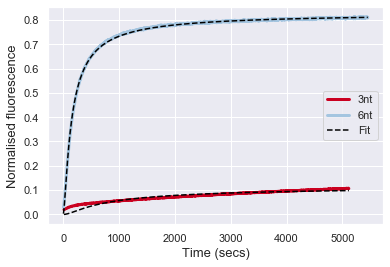

In [4]:
#average across the three replicates
sns.set()
color=['red', '#ca0020', '#a4c5e0']
labels = ['1nt', '3nt', '6nt']
toehold_lengths = [RD1, RD3, RD6]
#loop through the TMSD experiments
for ind, th_len in enumerate(toehold_lengths):
    
    #establish empty matrices for time, the initial signal, and the fluorescence over time
    time = np.empty((len(th_len[:, 0]), 3))
    init = np.empty((3))
    fluor = np.empty((len(th_len[:, 0]), 3))
    
    #fill the matrices the with the data for the TMSD experiments
    time[:, ind] = th_len[:,0]
    init[ind] = np.mean(initial_signal[:, ind + 10])
    fluor[:, ind] = th_len[:,1:].mean(axis = 1)
    
    print(FAM_decay[-1, 0])
    print(time[-1, ind])
    
    
    FAM_decay_time = FAM_decay[:, 0].tolist()
    time_time = time[:, ind].tolist()
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    if FAM_decay[0, 0] <= time[0, ind]:     
        start_time = FAM_decay_time.index(time[0, ind])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]), 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[:, ind], init[ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], init[ind]))
            time_molar = time[:, ind]
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]) - start_time, 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[:end_time+1, ind], init[ind]))/(np.subtract(FAM_decay[start_time:, 1], init[ind]))
            time_molar = time[:end_time + 1, ind]
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    else: 
        start_time = time_time.index(FAM_decay[0, 0])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]) - start_time, 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:, ind], init[ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], init[ind]))
            time_molar = time[start_time:, ind]
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]), 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:end_time+1, ind], init[ind]))/(np.subtract(FAM_decay[start_time:, 1], init[ind])) 
            time_molar = time[start_time:end_time+1, ind]
            
    '''#plot the average fluorescence against time
    plt.plot(time[:, ind], fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()

    #plot the average normalised fluorescence against time
    plt.plot(time_molar, molar_fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalised fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()'''
    
    #fit the experimental data to the bimolecular model using numerical integration 
    popt, pcov = fit_TMSD(time_molar, molar_fluor[:, ind])
    print('keff = ', popt[0])
    print('krep = ', popt[1])
    print('alpha = ', popt[2])
    print(pcov)
    #determine one standar deviation errors for the parameters 
    perr = np.sqrt(np.diag(pcov))
    print(perr)
    TMSD_sol = solve_TMSD(time_molar, *popt)
    
    #plot the numerical integration and the fits
    if ind in range(1, 3):
        plt.plot(time_molar, molar_fluor[:, ind], color[ind], linewidth = 3, label = labels[ind])
        if ind == 1:
            plt.plot(time_molar, TMSD_sol, '--', c='black', label = 'Fit')
        else:
            plt.plot(time_molar, TMSD_sol, '--', c='black')
ax = plt.gca()
plt.xticks(fontsize=11, fontname = 'Arial',)
plt.yticks(fontsize=11, fontname = 'Arial')
#rc('axes', linewidth=1.5)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]

ax.legend(handles,labels,loc='center right')
plt.xlabel('Time (secs)', fontsize = 13, fontname = 'Arial')   
plt.ylabel('Normalised fluorescence',  fontsize = 13, fontname = 'Arial')
plt.savefig('RNA-DNA keff.svg')
plt.show()

In [5]:
#define the function for the system of ODEs
def TMSD_system(concs_init, t, k_eff):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    I = concs_init[0]
    S = concs_init[1]
    SI = concs_init[2]
    O = concs_init[3]
    FQ = concs_init[4]
    OQ = concs_init[5]
    F = concs_init[6]
    
    k_rep = 10**5.568777350044678
    
    dI_dt = -k_eff*I*S
    dSI_dt = -dI_dt
    dS_dt = dI_dt
    
    dO_dt = k_eff*I*S - k_rep*O*FQ
    
    dOQ_dt = k_rep*O*FQ 
    dFQ_dt = - dOQ_dt 
    dF_dt = dOQ_dt
    
    return [dI_dt, dS_dt, dSI_dt, dO_dt, dFQ_dt, dOQ_dt, dF_dt]

#define the function which performs the integration of the system of ODEs
def solve_TMSD(t,k_eff, alpha):
    """SOLVES A SYSTEM OF ODES THROUGH NUMERICAL INTEGRATION
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param alpha: scaling constant
    :type alpha: int, float
    :return: numerical integration for the concentration of the fluorescently-labelled single strand over time"""
    I_init = alpha*60*10**-9
    S_init = alpha*60*10**-9 
    SI_init = 0 
    O_init = 0 
    FQ_init = alpha*60*10**-9
    OQ_init = 0 
    F_init = 0 
    
    t = np.hstack([[0], t])
    
    concs_init = [I_init, S_init, SI_init, O_init, FQ_init, OQ_init, F_init]
    
    soln = scint.odeint(TMSD_system,concs_init,t, args=(10**k_eff,), hmax = 20)
    return soln[1:,-1]/(60*10**-9)

#define the function which fits the integral to the experimental data
def fit_TMSD(t,F):
    """FITS SOLUTION OF NUMERICAL INTEGRATION TO EXPERIMENTAL DATA
    :param t: time over which the experiment was performed
    :type t: array
    :param F: initial concentration of the single fluorescently-labelled strand
    :type F: int, float
    :return: optimal estimates for the parameters and the covariance associated with these estimates"""
    popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,0.8], bounds=([1., 0],[7., 1.]))   
    return popt, pcov

5955.0
5223.0
keff =  6.999999999999999
alpha =  0.07550632043864167
[[ 8.34736035e-03 -1.91805789e-05]
 [-1.91805789e-05  7.98151478e-08]]
[0.09136389 0.00028252]
5955.0
5115.0
keff =  6.022699385970966
alpha =  0.10630842236629194
[[ 7.69122533e-04 -1.06739452e-05]
 [-1.06739452e-05  1.97382568e-07]]
[0.02773306 0.00044428]
5955.0
5454.0
keff =  5.445778213727644
alpha =  0.8294555117451483
[[ 1.38678716e-06 -1.00325708e-07]
 [-1.00325708e-07  1.39425964e-08]]
[0.00117762 0.00011808]


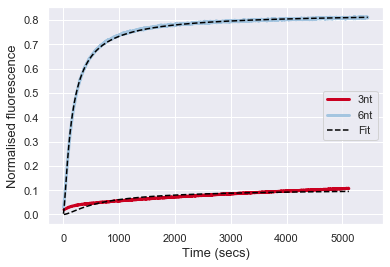

In [6]:
#average across the three replicates
sns.set()
color=['red', '#ca0020', '#a4c5e0']
labels = ['1nt', '3nt', '6nt']
toehold_lengths = [RD1, RD3, RD6]
#loop through the TMSD experiments
for ind, th_len in enumerate(toehold_lengths):
    
    #establish empty matrices for time, the initial signal, and the fluorescence over time
    time = np.empty((len(th_len[:, 0]), 3))
    init = np.empty((3))
    fluor = np.empty((len(th_len[:, 0]), 3))
    
    #fill the matrices the with the data for the TMSD experiments
    time[:, ind] = th_len[:,0]
    init[ind] = np.mean(initial_signal[:, ind + 10])
    fluor[:, ind] = th_len[:,1:].mean(axis = 1)
    
    print(FAM_decay[-1, 0])
    print(time[-1, ind])
    
    
    FAM_decay_time = FAM_decay[:, 0].tolist()
    time_time = time[:, ind].tolist()
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    if FAM_decay[0, 0] <= time[0, ind]:     
        start_time = FAM_decay_time.index(time[0, ind])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]), 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[:, ind], init[ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], init[ind]))
            time_molar = time[:, ind]
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]) - start_time, 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[:end_time+1, ind], init[ind]))/(np.subtract(FAM_decay[start_time:, 1], init[ind]))
            time_molar = time[:end_time + 1, ind]
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    else: 
        start_time = time_time.index(FAM_decay[0, 0])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]) - start_time, 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:, ind], init[ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], init[ind]))
            time_molar = time[start_time:, ind]
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]), 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:end_time+1, ind], init[ind]))/(np.subtract(FAM_decay[start_time:, 1], init[ind])) 
            time_molar = time[start_time:end_time+1, ind]
   
    '''#plot the average fluorescence against time
    plt.plot(time[:, ind], fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()

    #plot the average normalised fluorescence against time
    plt.plot(time_molar, molar_fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalised fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()'''
    
    #fit the experimental data to the bimolecular model using numerical integration 
    popt, pcov = fit_TMSD(time_molar, molar_fluor[:, ind])
    print('keff = ', popt[0])
    print('alpha = ', popt[1])
    print(pcov)
    #determine one standar deviation errors for the parameters 
    perr = np.sqrt(np.diag(pcov))
    print(perr)
    TMSD_sol = solve_TMSD(time_molar, *popt)
    
    #plot the numerical integration and the fits
    if ind in range(1, 3):
        plt.plot(time_molar, molar_fluor[:, ind], color[ind], linewidth = 3, label = labels[ind])
        if ind == 1:
            plt.plot(time_molar, TMSD_sol, '--', c='black', label = 'Fit')
        else:
            plt.plot(time_molar, TMSD_sol, '--', c='black')
ax = plt.gca()
plt.xticks(fontsize=11, fontname = 'Arial',)
plt.yticks(fontsize=11, fontname = 'Arial')
#rc('axes', linewidth=1.5)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]

ax.legend(handles,labels,loc='center right')
plt.xlabel('Time (secs)', fontsize = 13, fontname = 'Arial')   
plt.ylabel('Normalised fluorescence',  fontsize = 13, fontname = 'Arial')
plt.savefig('RNA-DNA keff fixed_krep.svg')
plt.show()

In [13]:
#define the function for the system of ODEs
def TMSD_system(concs_init, t, k_eff):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    I = concs_init[0]
    S = concs_init[1]
    SI = concs_init[2]
    O = concs_init[3]
    FQ = concs_init[4]
    OQ = concs_init[5]
    F = concs_init[6]
    
    k_rep = 10**5.543332643637821
    
    dI_dt = -k_eff*I*S
    dSI_dt = -dI_dt
    dS_dt = dI_dt
    
    dO_dt = k_eff*I*S - k_rep*O*FQ
    
    dOQ_dt = k_rep*O*FQ 
    dFQ_dt = - dOQ_dt 
    dF_dt = dOQ_dt
    
    return [dI_dt, dS_dt, dSI_dt, dO_dt, dFQ_dt, dOQ_dt, dF_dt]

#define the function which performs the integration of the system of ODEs
def solve_TMSD(t,k_eff, alpha):
    """SOLVES A SYSTEM OF ODES THROUGH NUMERICAL INTEGRATION
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param alpha: scaling constant
    :type alpha: int, float
    :return: numerical integration for the concentration of the fluorescently-labelled single strand over time"""
    I_init = alpha*60*10**-9
    S_init = alpha*60*10**-9 
    SI_init = 0 
    O_init = 0 
    FQ_init = alpha*60*10**-9
    OQ_init = 0 
    F_init = 0 
    
    
    concs_init = [I_init, S_init, SI_init, O_init, FQ_init, OQ_init, F_init]
    
    soln = scint.odeint(TMSD_system,concs_init,t, args=(10**k_eff,), hmax = 20)
    return soln[:,-1]/(60*10**-9)

#define the function which fits the integral to the experimental data
def fit_TMSD(t,F):
    """FITS SOLUTION OF NUMERICAL INTEGRATION TO EXPERIMENTAL DATA
    :param t: time over which the experiment was performed
    :type t: array
    :param F: initial concentration of the single fluorescently-labelled strand
    :type F: int, float
    :return: optimal estimates for the parameters and the covariance associated with these estimates"""
    popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,0.8], bounds=([1., 0],[8., 1.]))   
    return popt, pcov

keff =  7.999999999999964
alpha =  0.04870902403128268
[[ 4.71382630e-02 -1.41530918e-05]
 [-1.41530918e-05  8.65327739e-09]]
[2.17113479e-01 9.30229939e-05]
keff =  5.2646815730169045
alpha =  0.10484669209298776
[[ 2.48374025e-04 -1.00541152e-05]
 [-1.00541152e-05  4.31286424e-07]]
[0.01575989 0.00065672]
keff =  5.45374739859945
alpha =  0.8235707872518662
[[ 1.04205322e-06 -7.38494288e-08]
 [-7.38494288e-08  1.00227854e-08]]
[0.00102081 0.00010011]


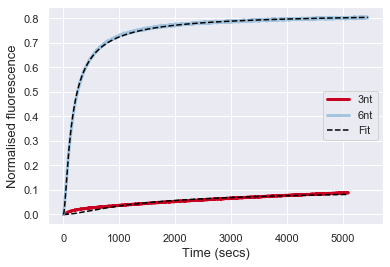

In [14]:
#average across the three replicates
sns.set()
color=['red', '#ca0020', '#a4c5e0']
labels = ['1nt', '3nt', '6nt']
toehold_lengths = [RD1, RD3, RD6]
#loop through the TMSD experiments
for ind, th_len in enumerate(toehold_lengths):
    
    #establish empty matrices for time, the initial signal, and the fluorescence over time
    time = np.empty((len(th_len[:, 0]), 3))
    fluor = np.empty((len(th_len[:, 0]), 3))
    
    #fill the matrices the with the data for the TMSD experiments
    time[:, ind] = th_len[:,0]
    fluor[:, ind] = th_len[:,1:].mean(axis = 1)
    

    FAM_decay_time = FAM_decay[:, 0].tolist()
    time_time = time[:, ind].tolist()
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    if FAM_decay[0, 0] <= time[0, ind]:     
        start_time = FAM_decay_time.index(time[0, ind])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]), 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[:, ind], fluor[0, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[0, ind]))
            time_molar = np.subtract(time[:, ind], time[0, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]) - start_time, 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[:end_time+1, ind], fluor[0, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[0, ind]))
            time_molar = np.subtract(time[:end_time + 1, ind], time[0, ind])
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    else: 
        start_time = time_time.index(FAM_decay[0, 0])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]) - start_time, 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[start_time, ind]))
            time_molar = np.subtract(time[start_time:, ind], time[start_time, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]), 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:end_time+1, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[start_time, ind])) 
            time_molar = np.subtract(time[start_time:end_time+1, ind], time[start_time, ind])
    
    '''#plot the average fluorescence against time
    plt.plot(time[:, ind], fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()

    #plot the average normalised fluorescence against time
    plt.plot(time_molar, molar_fluor[:, ind], label = labels[ind])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalised fluorescence')
    plt.title('Fluorescence trace for DNA/DNA toehold-mediated strand displacement')
    plt.legend()
    plt.show()'''
    
    #fit the experimental data to the bimolecular model using numerical integration 
    popt, pcov = fit_TMSD(time_molar, molar_fluor[:, ind])
    print('keff = ', popt[0])
    print('alpha = ', popt[1])
    print(pcov)
    #determine one standar deviation errors for the parameters 
    perr = np.sqrt(np.diag(pcov))
    print(perr)
    TMSD_sol = solve_TMSD(time_molar, *popt)
    
    #plot the numerical integration and the fits
    if ind in range(1, 3):
        plt.plot(time_molar, molar_fluor[:, ind], color[ind], linewidth = 3, label = labels[ind])
        if ind == 1:
            plt.plot(time_molar, TMSD_sol, '--', c='black', label = 'Fit')
        else:
            plt.plot(time_molar, TMSD_sol, '--', c='black')
ax = plt.gca()
plt.xticks(fontsize=11, fontname = 'Arial',)
plt.yticks(fontsize=11, fontname = 'Arial')
#rc('axes', linewidth=1.5)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]

ax.legend(handles,labels,loc='center right')
plt.xlabel('Time (secs)', fontsize = 13, fontname = 'Arial')   
plt.ylabel('Normalised fluorescence',  fontsize = 13, fontname = 'Arial')
plt.savefig('RNA-DNA keff fixed_krep no_init.svg')
plt.show()